In [1]:
import sys
sys.path.append('../src')

In [2]:
from gso.manifolds import AlgebraicManifold, plot_manifold
from gso.graph_sampling import GraphSampler
from gso.signal_generation import SignalGenerator
from gso.gso_learning import GraphLaplacianEstimator
from gso.gso_learning import relaxed_mle_laplacian, plot_attributed_graph

In [3]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
import csv
import pandas as pd

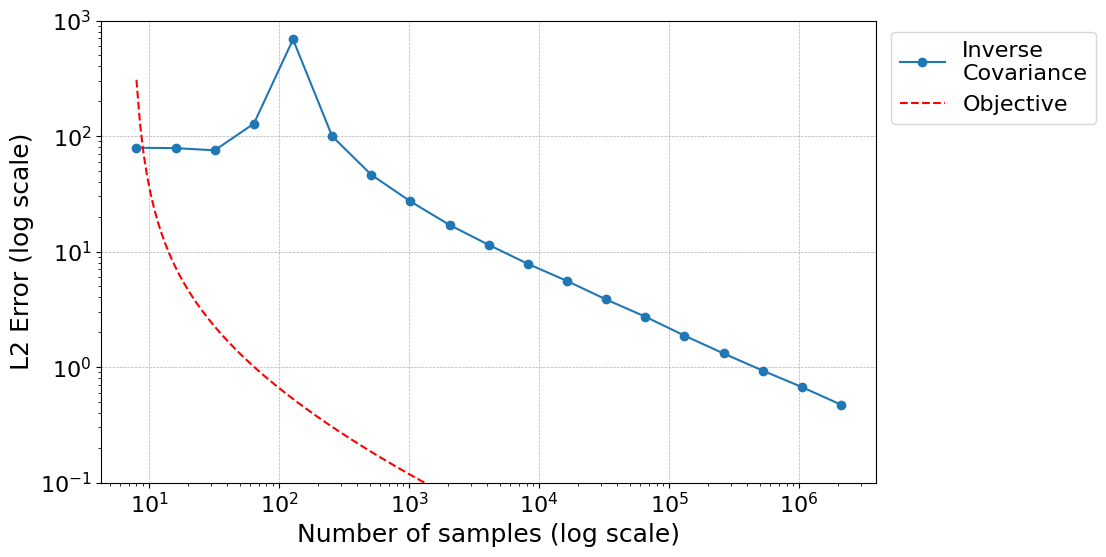

In [4]:
data = pd.read_csv('results_invcov.csv')
x = data['n_samples']
errors = data['fro_error']

plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-', label='Inverse\nCovariance')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)', fontsize=18)
plt.ylabel('L2 Error (log scale)', fontsize=18)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

x_model = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
# a = errors.iloc[0]  # Start at first data point
# b = 0.05            # Controls steepness
# k = 0.5             # Controls curvature (try 0.5 for a visible curve)

# y_model = a * np.exp(-b * x_model**k)

c = 2 - x.min()  # Ensure log argument > 0
a = errors.iloc[0] * np.log(x.iloc[0] + c) + 100
p = 0.2  # Try p between 0.5 and 1 for moderate extra decay set to 0 to recover previous
k = 3    # Try 2 or higher for faster decay
y_model = a / (x_model ** p * np.log(x_model + c) ** k)


plt.plot(x_model, y_model, 'r--', label='Objective')
plt.legend(loc='upper left',bbox_to_anchor=(1.005, 1),fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(1e-1, 1e3)
plt.savefig('invcov_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Visualizing Attributed Graphs

In [14]:
# G = nx.karate_club_graph()
# G = nx.krackhardt_kite_graph()
# G = nx.les_miserables_graph()
# G = nx.barabasi_albert_graph(20, 2)

n = 20      # Number of nodes
k = 4        # Each node is connected to k nearest neighbors in ring topology
p = 0.1      # Probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)

# sizes = [10, 8, 6]
# probs = np.array([[0.3, 0.01, 0.02],
#                   [0.01, 0.25, 0.03],
#                   [0.02, 0.03, 0.2]])
# while True:
#     G = nx.stochastic_block_model(sizes, probs)
#     if nx.is_connected(G):
#         break

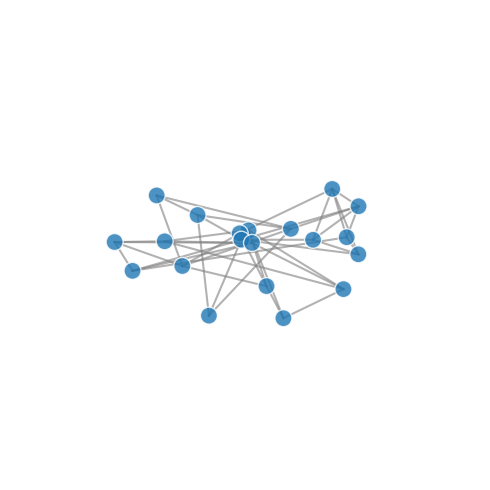

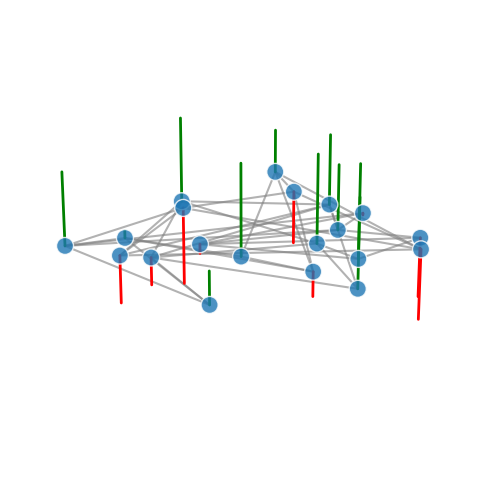

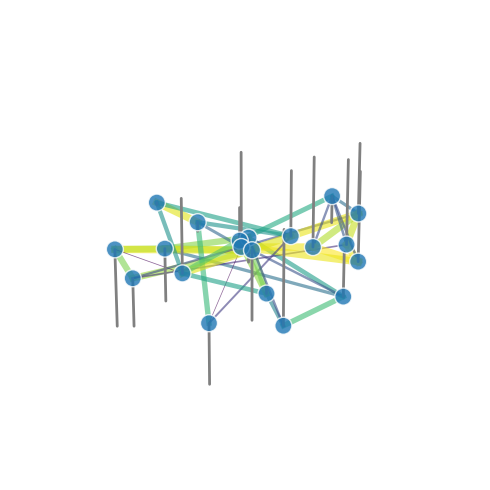

In [35]:
for node in G.nodes:
    G.nodes[node]['value'] = np.random.uniform(-2, 2)

diffs = [abs(G.nodes[u]['value'] - G.nodes[v]['value']) for u, v in G.edges()]
min_diff, max_diff = min(diffs), max(diffs)
weights = [(max_diff - diff) / (max_diff - min_diff) for diff in diffs]
for (u, v), weight in zip(G.edges(), weights):
    G.edges[u, v]['weight'] = weight

_ = plot_attributed_graph(G, edge_alpha=0.6, k=5, node_size=150, dpi=500, #elev=10, azim=135,
                     fig_title="simplegraph_2", save_format="png")
ax = plot_attributed_graph(G,value_attr='value', edge_alpha=0.6, k=5, node_size=150, dpi=800, #elev=10, azim=135, node_scale=0.1,
                     fig_title="graphsignal_2", save_format="png", layout="kamada-kawai")
_ = plot_attributed_graph(G, pos_color='grey', neg_color='grey', edge_alpha=0.6, node_size=150, dpi=500, #elev=10, azim=135,
                      value_attr='value', edge_attr='weight', k=5,
                      weight_as_width=True, min_edge_width=0.5, edge_scale=5,
                     fig_title="attributedgraph_2", save_format="png")

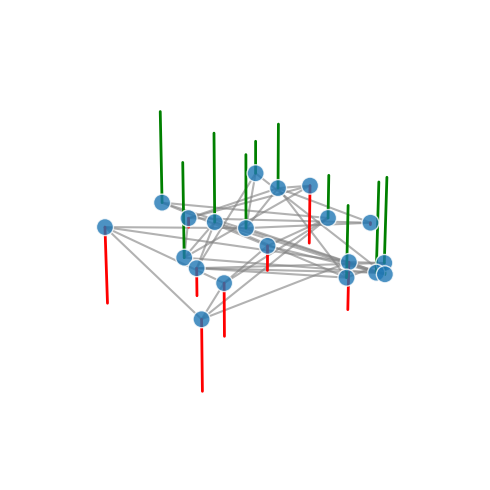

In [43]:
ax = plot_attributed_graph(G,value_attr='value', edge_alpha=0.6, k=5, node_size=150, dpi=1000, #elev=10, azim=135, node_scale=0.1,
                     fig_title="graphsignal_final", save_format="png", layout="kamada-kawai")

## Results from MLE

In [5]:
def create_sbm(sizes: list, probs: list, seed=None) -> csr_matrix:
    g = nx.stochastic_block_model(sizes, probs, seed=seed)
    return nx.adjacency_matrix(g).tocsr()

sizes = [33, 33, 33]
probs = np.array([[0.3, 0.01, 0.02],
                  [0.01, 0.25, 0.03],
                  [0.02, 0.03, 0.2]])
structure = create_sbm(sizes, probs)

In [6]:
num_equations = 2
num_variables = 4
max_degree = 4
seed = 22

M = AlgebraicManifold(num_equations, num_variables, max_degree, seed)

print(M)

AlgebraicManifold(num_equations=2, num_variables=4, max_degree=4, random_seed=22)


In [6]:
L, W, point_cloud, epsilon = GraphSampler().create_weighted_graph_from_structure(M, structure)
S = SignalGenerator(28).generate_gaussian_signal(L, 500000)
print(S.shape)

(500000, 99)


In [10]:
errors = []
x = []
L_dense = L.toarray()
for i in range(3, 22):
    n_samples = 2**i
    x.append(n_samples)
    print("Generating", n_samples, "samples")
    S = SignalGenerator().generate_gaussian_signal(L, n_samples, method="SG")
    L_hat = relaxed_mle_laplacian(S)
    error = np.linalg.norm(L_dense - L_hat, ord='fro')
    errors.append(error)

Generating 8 samples
Generating 16 samples
Generating 32 samples
Generating 64 samples
Generating 128 samples
Generating 256 samples
Generating 512 samples
Generating 1024 samples
Generating 2048 samples
Generating 4096 samples
Generating 8192 samples
Generating 16384 samples
Generating 32768 samples
Generating 65536 samples
Generating 131072 samples
Generating 262144 samples
Generating 524288 samples
Generating 1048576 samples
Generating 2097152 samples


In [11]:
data = np.column_stack((x, errors))
np.savetxt('results_rMLE.csv', data, delimiter=',', header='n_samples,fro_error', comments='')

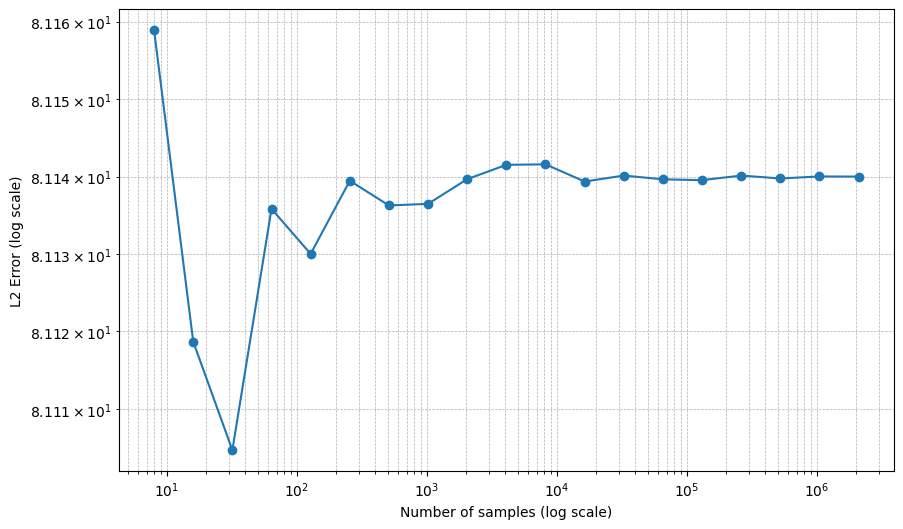

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('L2 Error (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Comparing different methods

In [7]:
L, W, point_cloud, epsilon = GraphSampler().create_weighted_graph_from_structure(M, structure)
L_dense = L.toarray()
np.fill_diagonal(L_dense, 0)

errors = []
x = []

for i in range(5, 10):
    n_samples = 2**i
    x.append(n_samples)
    print("Generating", n_samples, "samples")

    X = SignalGenerator().generate_gaussian_signal(L, n_samples, method="SG")
    
    pdet_estimator = GraphLaplacianEstimator().fit(X)
    fro_estimator = GraphLaplacianEstimator(method='frobenius').fit(X)
    mcp_estimator = GraphLaplacianEstimator(method='mcp').fit(X)
    
    error_pdet = np.linalg.norm(L_dense - pdet_estimator.laplacian, ord='fro')
    error_fro = np.linalg.norm(L_dense - fro_estimator.laplacian, ord='fro')
    error_mcp = np.linalg.norm(L_dense - mcp_estimator.laplacian, ord='fro')
    
    errors.append((error_pdet, error_fro, error_mcp))

with open('mle_errors_by_sample_size.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_samples', 'error_pdet', 'error_fro', 'error_mcp'])
    for n, (e_pdet, e_fro, e_mcp) in zip(x, errors):
        writer.writerow([n, e_pdet, e_fro, e_mcp])

Generating 32 samples


AttributeError: 'GraphLaplacianEstimator' object has no attribute 'Sigma'

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('L2 Error (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Diffusion Map

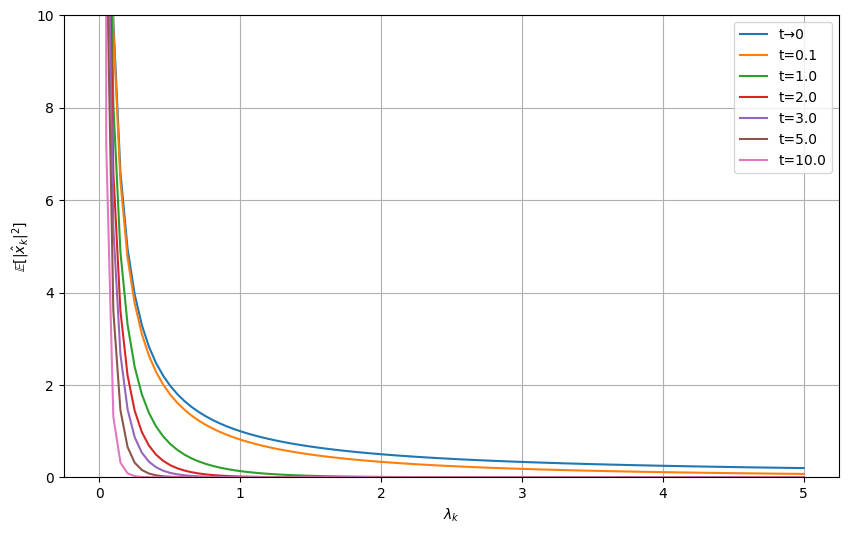

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Given t values
t_values = np.array([0.1, 1, 2, 3, 5, 10])

# Define a range of lambda_k values
lambda_k = np.linspace(0.00001, 5, 100)  # Avoid zero to prevent division by zero

# Calculate the power law for each t and lambda_k
power_law_values = {}
for t in t_values:
    power_law_values[t] = np.exp(-2 * t * lambda_k) / lambda_k

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lambda_k, 1 / lambda_k, label='t→0')
for t in t_values:
    plt.plot(lambda_k, power_law_values[t], label=f't={t}')

# plt.title('Power Law of a Diffusion Map')
plt.xlabel(r'$\lambda_k$')
plt.ylabel(r'$\mathbb{E}[|\hat{x}_k|^2]$')
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.savefig(f"power_law.png", dpi=300, bbox_inches="tight")
plt.show()